In [160]:
import geopandas as gp
import pandas as pd
from tqdm import tqdm
import numpy as np
import libpysal
import itertools
from joblib import Parallel, delayed

In [3]:
# load data frames (~ 40 secs)
import load_geolife

In [4]:
# Load preprocessed data 
raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf = load_geolife.geolife_raw_full_trip_gdf, load_geolife.geolife_raw_sp_gdf, load_geolife.geolife_raw_ep_gdf, load_geolife.geolife_tesselation_gdf
assert len(raw_full_trip_gdf) == len(raw_trip_sp_gdf) == len(raw_trip_ep_gdf)

In [5]:
def select_n_random_users_from_dataframes(n, raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf):
    """Select n random users from the dataset.

    Args:
        n (_type_): Number of users to select.
    """
    # Select n random users
    users = np.random.choice(raw_full_trip_gdf['PERSON_ID'].unique(), n, replace=False)
    # Filter dataframes
    raw_full_trip_gdf = raw_full_trip_gdf[raw_full_trip_gdf['PERSON_ID'].isin(users)]
    raw_trip_sp_gdf = raw_trip_sp_gdf[raw_trip_sp_gdf['PERSON_ID'].isin(users)]
    raw_trip_ep_gdf = raw_trip_ep_gdf[raw_trip_ep_gdf['PERSON_ID'].isin(users)]
    return raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf


In [7]:
# Select n random person ids from the dataset
n_users = 30
raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf = select_n_random_users_from_dataframes(n_users, raw_full_trip_gdf, raw_trip_sp_gdf, raw_trip_ep_gdf)

## Evaluation Functions

In [8]:
from sklearn import metrics
from scipy.optimize import linear_sum_assignment

def getGroundTruth():
    # Get ground truth labels
    df = full_trip_gdf
    df['ID'] = df.sort_values('TRIP_ID').groupby('PERSON_ID').ngroup() # Sort TRIP ID ascending and set cluster id corresponding to PERSON_ID
    ground_truth = df.sort_values('TRIP_ID').ID.to_list()
    return ground_truth

def getContingencyMatrix(clustering):
    # Get ground truth labels
    ground_truth = getGroundTruth()
    cm = metrics.cluster.contingency_matrix(ground_truth, clustering)
    row_idx, col_idx = linear_sum_assignment(-cm) # resort contingency matrix to maximize sum of diagonal
    cm = cm[:, col_idx] # reorder columns based on indices
    cm = cm[row_idx, :] # reorder rows based on indices
    return cm

def getConfusionMatrix(clustering):
    # Get ground truth labels
    ground_truth = getGroundTruth()
    cm = metrics.confusion_matrix(ground_truth, clustering)
    row_idx, col_idx = linear_sum_assignment(-cm) # resort confusion matrix to maximize sum of diagonal
    cm = cm[:, col_idx] # reorder columns based on indices
    cm = cm[row_idx, :] # reorder rows based on indices
    return cm

def getAccuracyAtOne(ground_truth, clustering):
    cm = getContingencyMatrix(clustering)
    # Reorder rows and columns to maximize sum of diagonal
    # Vgl: https://smorbieu.gitlab.io/accuracy-from-classification-to-clustering-evaluation/#:~:text=Computing%20accuracy%20for%20clustering%20can,the%20accuracy%20for%20clustering%20results.
    row_idx, col_idx = linear_sum_assignment(-cm)
    return cm[row_idx,col_idx].sum()/cm.sum()

def getPrecision(ground_truth, clustering):
    cm = getContingencyMatrix(clustering)
    row_idx, col_idx = linear_sum_assignment(-cm) # resort confusion matrix to maximize sum of diagonal
    cm = cm[:, col_idx] # reorder columns based on indices
    cm = cm[row_idx, :] # reorder rows based on indices

    # Calculate precision
    precision = np.diag(cm) / np.sum(cm, axis = 0)

    # Return unweighted mean of precision
    return np.mean(precision)

def getRecall(ground_truth, clustering):
    cm = getContingencyMatrix(clustering)
    
    # Calculate recall
    recall = np.diag(cm) / np.sum(cm, axis = 1)

    # Return unweighted mean of recall
    return np.mean(recall)

def getF1Score(ground_truth, clustering):
    precision = getPrecision(ground_truth, clustering)
    recall = getRecall(ground_truth, clustering)
    return 2 * (precision * recall) / (precision + recall)

def evaluate(clustering):
    # Get ground truth labels
    ground_truth = getGroundTruth()

    # Not symmetric and not accounting for chance
    print(f"Accuracy@1: {getAccuracyAtOne(ground_truth, clustering):.3f}")
    print(f"Precision: {getPrecision(ground_truth, clustering):.3f}")
    print(f"Recall: {getRecall(ground_truth, clustering):.3f}")
    print(f"F1: {getF1Score(ground_truth, clustering):.3f}")
    print(f"Homogeneity: {metrics.homogeneity_score(ground_truth, clustering):.3f}")
    print(f"Completeness: {metrics.completeness_score(ground_truth, clustering):.3f}")

    # All of these metrics are symmetric and some of them are accounting for chance depending on the number of classes and clusters present in the data
    print(f"V-measure: {metrics.v_measure_score(ground_truth, clustering):.3f}")
    print(f"Rand index: {metrics.rand_score(ground_truth, clustering):.3f}")
    print(f"ARI: {metrics.adjusted_rand_score(ground_truth, clustering):.3f}")
    print(f"MI: {metrics.mutual_info_score(ground_truth, clustering):.3f}")
    print(f"NMI: {metrics.normalized_mutual_info_score(ground_truth, clustering):.3f}")
    print(f"AMI: {metrics.adjusted_mutual_info_score(ground_truth, clustering):.3f}")

In [9]:
import tslearn.metrics

def LCSS(traj1_linestr, traj2_linestr, eps=10):
    """This function takes in two GeoSeries and takes the top entry linestring. It then calculates the Least Common Sub-Sequence metric for these two and returns the value.

    Args:
        traj1_linestr (_type_): _description_
        traj2_linestr (_type_): _description_
        eps (int, optional): This can be interpreted as the distance in meters between two points compared of the subsequences. Defaults to 10.

    Returns:
        _type_: float
    """
    assert isinstance(traj1_linestr, gp.GeoSeries), f"traj1_linestr is of type {type(traj1_linestr)}, need to be GeoSeries"
    assert isinstance(traj2_linestr, gp.GeoSeries), f"traj2_linestr is of type {type(traj2_linestr)}, need to be GeoSeries"

    s1 = traj1_linestr.iloc[0].coords
    s2 = traj2_linestr.iloc[0].coords

    return tslearn.metrics.lcss(s1, s2, eps=eps)

# Merge Start Points (SP) and End Points (EP) with Tessellation

In [10]:
def match_boundary_points_with_tessellation(raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf):
    """This function matches the boundary points of the raw trips with the tesselation. 

    Args:
        raw_trip_sp_gdf (_type_): _description_
        raw_trip_ep_gdf (_type_): _description_
        tesselation_gdf (_type_): _description_

    Returns:
        _type_: This function returns two data frames, one for the start points and one for the end points. These data frames contain the tile_id of the tesselation that the point is located in.
    """
    # SP
    # Spatial join points to polygons
    gdf_sp = gp.sjoin(
        tesselation_gdf[["tile_id", "geometry"]],
        raw_trip_sp_gdf,
        how="inner"
    ).drop('index_right', axis=1)

    # Spatial join points to polygons
    gdf_ep = gp.sjoin(
        tesselation_gdf[["tile_id", "geometry"]],
        raw_trip_ep_gdf,
        how="inner"
    ).drop('index_right', axis=1)

    return gdf_sp, gdf_ep

In [11]:
gdf_sp, gdf_ep = match_boundary_points_with_tessellation(raw_trip_sp_gdf, raw_trip_ep_gdf, tesselation_gdf)

# Extract Full Trips that Start and End within Tessellation Area

In [13]:
gdf_sp_ids = gdf_sp.TRIP_ID
gdf_ep_ids = gdf_ep.TRIP_ID

full_trip_gdf = raw_full_trip_gdf.query("TRIP_ID in @gdf_sp_ids and TRIP_ID in @gdf_ep_ids")
trip_sp_gdf = raw_trip_sp_gdf.query("TRIP_ID in @gdf_ep_ids")
trip_ep_gdf = raw_trip_ep_gdf.query("TRIP_ID in @gdf_sp_ids")

gdf_sp = gdf_sp.query("TRIP_ID in @gdf_ep_ids")
gdf_ep = gdf_ep.query("TRIP_ID in @gdf_sp_ids")

assert len(full_trip_gdf) == len(trip_sp_gdf) == len(trip_ep_gdf) == len(gdf_sp) == len(gdf_ep) == len(set(trip_sp_gdf.TRIP_ID).intersection(set(trip_ep_gdf.TRIP_ID))) # this last intersection checks that for all unique trip ids we have exactly ONE SP and EP

print(f"Number of trips that start and end wihin tessellation area: {len(full_trip_gdf)}")
print(f"Number of trips outside and therefore dropped: {len(raw_full_trip_gdf) - len(full_trip_gdf)}")

Number of trips that start and end wihin tessellation area: 4108
Number of trips outside and therefore dropped: 639


## Build mapping of trip chains

In [14]:
def build_trip_chain_mapping(gdf_sp, gdf_ep, INFLOW_HR_DIFF_THRESHOLD=4, HR_DIFF_THRESHOLD=8):
    """This function returns a list of trip chains that are continued trips that happened subsequent to and from same tile within a given time threshold.

    Args:
        gdf_sp (_type_): _description_
        gdf_ep (_type_): _description_
        inflow_hr_diff_threshold (int, optional): _description_. Defaults to 4.
        hr_diff_threshold (int, optional): _description_. Defaults to 8.

    Returns:
        _type_: _description_
    """

    # Calculate mapping of continued trips that happened subsequent to and from same tile
    mapping_cont_trips = []
    for index, trip in tqdm(gdf_ep.sort_values('TRIP_ID').iterrows(), total=len(gdf_ep)):
        te_1_id = trip.TRIP_ID
        te_1_tid = trip.tile_id
        te_1_dt = pd.to_datetime(trip['TRIP_END'], format='%Y-%m-%d %H:%M:%S')
        ts_1_dt = pd.to_datetime(trip['TRIP_START'], format='%Y-%m-%d %H:%M:%S')

        inflow = gdf_ep.query("tile_id == @te_1_tid").copy()
        inflow['TRIP_END'] = inflow.TRIP_END.astype('datetime64[ns]')
        inflow['TRIP_START'] = inflow.TRIP_START.astype('datetime64[ns]')
        inflow['INFLOW_HR_DIFF'] = inflow.TRIP_END.apply(lambda x: (x - te_1_dt).total_seconds()/3600)
        inflow = inflow.query("(INFLOW_HR_DIFF <= @INFLOW_HR_DIFF_THRESHOLD) and (INFLOW_HR_DIFF >= @INFLOW_HR_DIFF_THRESHOLD)") # Take trips 
        inflow = inflow.query("(TRIP_START > @te_1_dt) or (@ts_1_dt > TRIP_END)") # Ignore trips that have happened simultaneously

        # if more than one trip has arrived in +- hour window, then do not merge this trip
        if len(inflow) > 1:
            continue

        
        # Get all trips that started from same tile as t_1 has ended in
        ts_2 = gdf_sp.query("tile_id == @te_1_tid").copy()

        # get difference between two trips hours (seconds divided by 3600 gets hours)
        ts_2['TRIP_START'] = ts_2.TRIP_START.astype('datetime64[ns]')
        ts_2['TRIP_END'] = ts_2.TRIP_END.astype('datetime64[ns]')
    
        ts_2['hr_diff'] = ts_2['TRIP_START'].apply(lambda x: (x - te_1_dt).total_seconds()/3600)

        # Only consider trips that started within a certain time after the initial trip ended in the same tessellation tile
        ts_2 = ts_2[(ts_2['hr_diff'].astype(str).astype(float) <= HR_DIFF_THRESHOLD) & (ts_2['hr_diff'].astype(str).astype(float) >= 0)]

        # Only consider trips that are not simultaneously
        ts_2 = ts_2.query("(TRIP_START > @te_1_dt) or (@ts_1_dt > TRIP_END)")

        # Only consider connection if exactly one trip started from same tile in time window
        if len(ts_2) == 1:
            mapping_cont_trips.append({
                'TRIP_ID': te_1_id,
                'TRIP_ID_CONT': ts_2.TRIP_ID.iloc[0]
            })

    return mapping_cont_trips
    


In [15]:
mapping_cont_trips = build_trip_chain_mapping(gdf_sp, gdf_ep)

100%|██████████| 4108/4108 [01:02<00:00, 65.24it/s]


In [16]:
def evaluate_trip_chaining(mapping_cont_trips, full_trip_gdf):
    """This function evaluates the trip chaining by checking if the chained trips are from the same person.

    Args:
        mapping_cont_trips (_type_): Dictionary of trip ids that are chained. Output of build_trip_chain_mapping()
        full_trip_gdf (_type_): The full trip gdf that contains all trips.
    Returns:
        _type_: None
    """
    mistakes = []
    for conn in mapping_cont_trips:
        trip_ids = [conn['TRIP_ID'],  conn['TRIP_ID_CONT']]
        unique_person = full_trip_gdf.query("TRIP_ID in @trip_ids").PERSON_ID.nunique()

        if unique_person > 1:
            mistakes.append(full_trip_gdf.query("TRIP_ID in @trip_ids"))


    print(f"Number of edges (matched) between trips: {len(mapping_cont_trips)}")
    print(f"Number of wrong matches: {len(mistakes)}")


In [17]:
evaluate_trip_chaining(mapping_cont_trips, full_trip_gdf)

Number of edges (matched) between trips: 1491
Number of wrong matches: 18


## Merge trips according to matching

In [18]:
def getTripChain(trip_id, mapping_cont_trips, chain=[]):
    """ Recursive function that returns a list for all chained trips for a give orig trip_id


    Args:
        trip_id (_type_): _description_
        chain (list, optional): _description_. Defaults to [].
        mapping_cont_trips (_type_): Mapping of continued trips. Output of build_trip_chain_mapping().

    Returns:
        _type_: _description_
    """
    if type(trip_id) == str:
        trip_id = int(trip_id)

    # add orig trip_id to output list
    if len(chain) == 0:
        chain.append(trip_id)

    # recursively find all chained trips originating from the orig trip_id
    for edge in mapping_cont_trips:
        if edge['TRIP_ID'] == trip_id:
            chain.append(edge['TRIP_ID_CONT'])
            getTripChain(edge['TRIP_ID_CONT'], mapping_cont_trips, chain)
            
        
    return chain

In [19]:
def merge_trips_from_matching(gdf_sp, mapping_cont_trips, full_trip_gdf):
    """This function merges trips that are chained together from the matching done in build_trip_chain_mapping().

    Args:
        gdf_sp (_type_): GeoDataFrame of start points.
        mapping_cont_trips (_type_): Mapping of continued trips. Output of build_trip_chain_mapping().
        full_trip_gdf (_type_): GeoDataFrame of all trips.

    Returns:
        _type_: GeoDataFrame of merged trips.
    """
    # Get trip chain for each trip (Start Point)
    print("Building trip chains...")
    trip_chains = [getTripChain(trip, mapping_cont_trips, chain=[]) for trip in tqdm(gdf_sp.TRIP_ID)]
    print("Done.")

    # Sort for longest chain first
    trip_chains.sort(key = len, reverse = True)

    # Create dictionary to store mappings for evaluation
    trip_concat_dict = {}

    covered_trips = []
    merged_trips_gdf = []
    print("Merging trips...")
    for chain in tqdm(trip_chains, total=len(trip_chains)):
        # Check if any of the trips in the current chain has already been merged as part of another chain
        # Since we start with the longest chain and iterate through descending sorted list, we only retain the complete chains
        if set(chain).intersection(set(covered_trips)):
            continue

        # add trip chain to dict for evaluation later
        trip_concat_dict[chain[0]] = chain[1:]
        
        # add all trip ids part of current chain to list so that every trip is only contained in longest chain of it
        covered_trips += chain

        trips = full_trip_gdf.query("TRIP_ID in @chain").sort_values("TRIP_START")
        trips["temp"] = 1

        trips = trips.groupby('temp').agg(list).reset_index(drop=True).rename(columns={'TRIP_ID': 'TRIP_ID_CHAIN'})

        trips["wkt_trip"] = trips['geometry'].apply(lambda x: ", ".join([str(i) for i in x]).replace("), LINESTRING (", ", "))
        trips['TRIP_START'] = trips['TRIP_START'].apply(lambda x: min(x))
        trips['TRIP_END'] = trips['TRIP_END'].apply(lambda x: max(x))
        trips['TRIP_LEN_IN_MTRS'] = trips['TRIP_LEN_IN_MTRS'].apply(lambda x: sum(x))
        #trips['TRIP_DURATION_IN_SECS'] = trips['TRIP_DURATION_IN_SECS'].apply(lambda x: sum(x))
        trips['TRIP_WD'] = trips['TRIP_WD'].apply(lambda x: x[0]) # see below
        trips['TRIP_DATE'] = trips['TRIP_DATE'].apply(lambda x: x[0]) # see below
        trips['TRIP_ID'] = trips['TRIP_ID_CHAIN'].apply(lambda x: x[0]) # assign trip_id of first trip in chain to concatenated trip
        # This is the TRIP_ID of the last trip in the chain to be concatenated
        trips['TRIP_ID_LAST'] = trips['TRIP_ID_CHAIN'].apply(lambda x: x[-1]) 

        # Note: Here we are assigning the PERSON_ID of the first trip to the concatenated trip. This of course can be erroneous if the concatenation itself is wrong
        trips['PERSON_ID'] = trips['PERSON_ID'].apply(lambda x: x[0])
        trips = trips.drop(['geometry', 'TRIP_ID_CHAIN'], axis=1)

        trips = gp.GeoDataFrame(trips, geometry=gp.GeoSeries.from_wkt(trips['wkt_trip'])).drop('wkt_trip', axis=1)

        merged_trips_gdf.append(trips)
    print("Done.")

    trip_merged_gdf = pd.concat(merged_trips_gdf)

    print(f"Number of trips that were matched at least once: {len(set(covered_trips))}/{len(set(gdf_sp.TRIP_ID))}")

    # Concatenate all trips that were unmerged with the merged trips into a new gdf
    print("Concatenating MERGED and UNMERGED trips...")
    unmerged_trips = full_trip_gdf.query("TRIP_ID not in @covered_trips")
    full_trips_concat_gdf = pd.concat([unmerged_trips, trip_merged_gdf])
    full_trips_concat_gdf['TRIP_ID_FIRST'] = full_trips_concat_gdf['TRIP_ID'] # This is the same as TRIP_ID
    print("Done.")

    # Assign TRIP_ID as TRIP_ID_LAST in case TRIP has not been merged and first and last TRIP_Id are in fact the same
    full_trips_concat_gdf['TRIP_ID_LAST'] = np.where(full_trips_concat_gdf.TRIP_ID_LAST.isnull(), full_trips_concat_gdf.TRIP_ID, full_trips_concat_gdf.TRIP_ID_LAST)


    return full_trips_concat_gdf.reset_index(drop=True), trip_concat_dict

In [20]:
full_trips_concat_gdf, trip_concat_dict = merge_trips_from_matching(gdf_sp, mapping_cont_trips, full_trip_gdf)

Building trip chains...


100%|██████████| 4108/4108 [00:00<00:00, 11024.90it/s]


Done.
Merging trips...


100%|██████████| 4108/4108 [00:33<00:00, 124.19it/s]


Done.
Number of trips that were matched at least once: 4069/4108
Concatenating MERGED and UNMERGED trips...
Done.


In [21]:
# Filter for those trip_ids that are still the start of a trip even after the concatenation (of trip chains)
t_id_sp = full_trips_concat_gdf.TRIP_ID_FIRST
t_id_ep = full_trips_concat_gdf.TRIP_ID_LAST

# Also filter dfs that contain points
gdf_sp_concat = gdf_sp.query("TRIP_ID in @t_id_sp")
trip_sp_gdf_concat = trip_sp_gdf.query("TRIP_ID in @t_id_sp")

gdf_ep_concat = gdf_ep.query("TRIP_ID in @t_id_ep")
trip_ep_gdf_concat = trip_ep_gdf.query("TRIP_ID in @t_id_ep")

assert len(trip_sp_gdf_concat) == len(trip_ep_gdf_concat) == len(gdf_sp_concat) == len(gdf_ep_concat)

## Build Clustering after Concatenation Step

In [23]:
def getIndexInList(trip_id, full_trip_gdf):
    """This function takes in a trip_id and returns the list index of this trip's position in the ground truth clustering.

    Args:
        trip_id (int): TRIP_ID

    Returns:
        int: The index of this TRIP_ID in the ground truth clustering vector.
    """
    index_list = full_trip_gdf.sort_values('TRIP_ID').TRIP_ID.to_list()

    return index_list.index(trip_id)


def build_clustering_after_concatenation(full_trips_concat_gdf, trip_concat_dict):
    """This function builds the clustering vector after the concatenation step.

    Args:
        full_trips_concat_gdf (GeoDataFrame): GeoDataFrame containing all trips after the concatenation step.
        trip_concat_dict (dict): Dictionary containing the trip chains that were concatenated.

    Returns:
        int: The index of this TRIP_ID in the ground truth clustering vector.
    """

    # This creates the array with clustering IDs after the concatenation step
    clustering_concat = {}
    for index, trip in full_trips_concat_gdf.reset_index().sort_values('TRIP_ID').iterrows():
        trip_order_index = getIndexInList(trip.TRIP_ID, full_trip_gdf)

        clustering_concat[trip_order_index] = index

        if trip.TRIP_ID in trip_concat_dict:
            for t in trip_concat_dict[trip.TRIP_ID]:
                clustering_concat[getIndexInList(t, full_trip_gdf)] = index

    clustering_concat = list(dict(sorted(clustering_concat.items())).values())

    print(f"Number of unique clusters: {len(set(clustering_concat))}")

    return clustering_concat


In [24]:
clustering_concat = build_clustering_after_concatenation(full_trips_concat_gdf, trip_concat_dict)

Number of unique clusters: 2656


# Build Home Locations (HL)

## From Start Points (SPs)

We use the SP-tessellation matching that still contains all SP (and potential HL), and not just the SP and EP of the concatenated trips. We do this, because we do not want loose potential HL contributed of substrip concatenated in a chain.

In [25]:
# Generate home locations (HL) from SPs
gdf_sp.index=pd.to_datetime(gdf_sp.TRIP_START)
gdf_sp['hl'] = gdf_sp['TRIP_START'].apply(lambda x: 1 if x in gdf_sp.between_time('6:00', '10:00').TRIP_START else 0).astype(object)
gdf_sp.reset_index(inplace=True, drop=True)
gdf_sp

,tile_id,geometry,TRIP_ID,TRIP_START,TRIP_END,TRIP_LEN_IN_MTRS,PERSON_ID,TRIP_WD,TRIP_DATE,hl
0,61,"POLYGON ((116.32913 39.97292, 116.32885 39.971...",2746,2008-05-30 06:50:51,2008-05-30 07:41:05,26841.362904,81,Friday,2008-05-30,1
1,61,"POLYGON ((116.32913 39.97292, 116.32885 39.971...",17211,2009-04-14 01:13:04,2009-04-14 01:21:54,1095.477838,22,Tuesday,2009-04-14,0
2,87,"POLYGON ((116.34883 39.92639, 116.34855 39.924...",23443,2009-09-20 15:55:00,2009-09-20 23:52:49,21171.250391,77,Sunday,2009-09-20,0
3,234,"POLYGON ((116.31312 39.94624, 116.31284 39.944...",12951,2009-02-14 03:31:24,2009-02-14 09:53:59,57720.799602,23,Saturday,2009-02-14,0
4,236,"POLYGON ((116.30315 39.99269, 116.30287 39.991...",18696,2009-05-10 03:20:28,2009-05-10 03:25:58,294.604029,22,Sunday,2009-05-10,0
...,...,...,...,...,...,...,...,...,...,...
4103,46601,"POLYGON ((116.41995 40.04515, 116.41967 40.043...",22339,2009-07-22 11:52:04,2009-07-22 12:05:29,1519.308675,144,Wednesday,2009-07-22,0
4104,46771,"POLYGON ((116.42411 39.93782, 116.42382 39.936...",9799,2008-12-10 07:22:33,2008-12-10 10:03:40,21315.514878,4,Wednesday,2008-12-10,1
4105,46797,"POLYGON ((116.44501 40.02048, 116.44473 40.018...",20077,2009-06-07 06:06:03,2009-06-07 06:29:09,7481.792024,144,Sunday,2009-06-07,1
4106,46797,"POLYGON ((116.44501 40.02048, 116.44473 40.018...",22766,2009-08-09 09:03:22,2009-08-09 09:21:52,1819.083467,144,Sunday,2009-08-09,1


In [26]:
# Extract only those cells that are HL
gdf_hl_sp = gdf_sp[gdf_sp['hl'] == 1]

In [27]:
# create spatial weights matrix
W = libpysal.weights.Queen.from_dataframe(gdf_hl_sp)

# get component labels
components = W.component_labels

gdf_hl_combined_sp = pd.merge(gp.sjoin(
    gdf_hl_sp,
    gdf_hl_sp.dissolve(by=components)[["geometry"]],
    how="left"
), gdf_hl_sp.dissolve(by=components)[["geometry"]].reset_index(), left_on="index_right", right_on='index', suffixes=("__drop", "")).drop(['index', 'index_right', 'geometry__drop'], axis=1)

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 150 disconnected components.
 There are 92 islands with ids: 4, 15, 20, 21, 25, 59, 95, 107, 109, 123, 124, 132, 137, 138, 142, 154, 162, 163, 166, 169, 205, 206, 207, 210, 212, 213, 218, 234, 235, 286, 287, 288, 293, 356, 357, 360, 363, 364, 372, 373, 391, 394, 402, 405, 448, 449, 451, 452, 453, 457, 462, 500, 502, 522, 526, 532, 537, 540, 545, 548, 563, 604, 607, 614, 618, 621, 643, 646, 647, 653, 655, 658, 668, 669, 673, 679, 680, 681, 684, 685, 686, 697, 810, 831, 834, 835, 838, 839, 840, 843, 846, 856.
  warnings.warn(message)


In [28]:
# Compute count of unique HL per Peson (HL here is already the merged tiles)
gdf_hl_combined_sp = pd.merge(gdf_hl_combined_sp, gdf_hl_combined_sp.astype({'geometry': 'string'}).groupby('PERSON_ID')[['geometry']].nunique().reset_index().rename(columns={'geometry': 'CNT_UNIQUE_HL'}), how="left")

# TODO: Add number of trips per merged tile
#gdf_hl_combined_sp = pd.merge(gdf_hl_combined_sp, gdf_hl_combined_sp.groupby(['PERSON_ID', 'geometry']).nunique().reset_index()[['PERSON_ID', 'TRIP_ID']].rename(columns={'TRIP_ID': 'CNT_TRIPS_PER_HL'}), suffixes=("", "_drop"))

# using dictionary to convert specific columns
convert_dict = {'PERSON_ID': object,
                'CNT_UNIQUE_HL': int
                }
 
gdf_hl_combined_sp = gdf_hl_combined_sp.astype(convert_dict)

## From End Points (EPs)

In [29]:
# Generate home locations (HL) from EPs
gdf_ep.index=pd.to_datetime(gdf_ep.TRIP_END)
gdf_ep['hl'] = gdf_ep['TRIP_END'].apply(lambda x: 1 if x in gdf_ep.between_time('18:00', '00:00').TRIP_END else 0).astype(object)
gdf_ep.reset_index(inplace=True, drop=True)
gdf_ep

,tile_id,geometry,TRIP_ID,TRIP_START,TRIP_END,TRIP_LEN_IN_MTRS,PERSON_ID,TRIP_WD,TRIP_DATE,hl
0,61,"POLYGON ((116.32913 39.97292, 116.32885 39.971...",21601,2009-07-07 04:55:30,2009-07-07 05:09:45,1278.079304,22,Tuesday,2009-07-07,0
1,87,"POLYGON ((116.34883 39.92639, 116.34855 39.924...",23442,2009-09-20 12:33:45,2009-09-20 15:39:58,17570.406856,77,Sunday,2009-09-20,0
2,87,"POLYGON ((116.34883 39.92639, 116.34855 39.924...",4687,2008-08-23 03:30:32,2008-08-23 03:36:52,390.323060,167,Saturday,2008-08-23,0
3,236,"POLYGON ((116.30315 39.99269, 116.30287 39.991...",18695,2009-05-10 02:09:07,2009-05-10 03:01:38,4756.662101,22,Sunday,2009-05-10,0
4,275,"POLYGON ((116.39991 39.96732, 116.39963 39.965...",9251,2008-12-02 09:38:47,2008-12-02 09:43:33,2591.080868,144,Tuesday,2008-12-02,0
...,...,...,...,...,...,...,...,...,...,...
4103,46601,"POLYGON ((116.41995 40.04515, 116.41967 40.043...",22339,2009-07-22 11:52:04,2009-07-22 12:05:29,1519.308675,144,Wednesday,2009-07-22,0
4104,46771,"POLYGON ((116.42411 39.93782, 116.42382 39.936...",9798,2008-12-10 06:10:43,2008-12-10 07:07:03,2873.847650,4,Wednesday,2008-12-10,0
4105,46797,"POLYGON ((116.44501 40.02048, 116.44473 40.018...",10876,2009-01-08 01:34:32,2009-01-08 01:45:39,650.239584,144,Thursday,2009-01-08,0
4106,46845,"POLYGON ((116.20342 39.90573, 116.20314 39.904...",11636,2009-01-20 04:56:47,2009-01-20 05:02:19,3322.760745,144,Tuesday,2009-01-20,0


In [30]:
# Extract only those cells that are HL
gdf_hl_ep = gdf_ep[gdf_ep['hl'] == 1]

In [31]:
### Merge hl cells that are adjacent (touching) to each other 

# create spatial weights matrix
W = libpysal.weights.Queen.from_dataframe(gdf_hl_ep)

# get component labels
components = W.component_labels

gdf_hl_combined_ep = pd.merge(gp.sjoin(
    gdf_hl_ep,
    gdf_hl_ep.dissolve(by=components)[["geometry"]],
    how="left"
), gdf_hl_ep.dissolve(by=components)[["geometry"]].reset_index(), left_on="index_right", right_on='index', suffixes=("__drop", "")).drop(['index', 'index_right', 'geometry__drop'], axis=1)

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 67 disconnected components.
 There are 43 islands with ids: 1, 2, 3, 4, 9, 12, 32, 37, 44, 49, 87, 94, 223, 224, 229, 230, 238, 247, 248, 250, 253, 254, 265, 266, 284, 320, 326, 328, 345, 355, 356, 360, 366, 367, 368, 369, 372, 376, 397, 398, 400, 402, 412.
  warnings.warn(message)


In [32]:
gdf_hl_combined_ep = pd.merge(gdf_hl_combined_ep, gdf_hl_combined_ep.astype({'geometry': 'string'}).groupby('PERSON_ID')[['geometry']].nunique().reset_index().rename(columns={'geometry': 'CNT_UNIQUE_HL'}), how="left")

# using dictionary to convert specific columns
convert_dict = {'PERSON_ID': object,
                'CNT_UNIQUE_HL': int
                }
 
gdf_hl_combined_ep = gdf_hl_combined_ep.astype(convert_dict)

## Merge (concatenate)

In [33]:
gp_combined = pd.concat([gdf_hl_combined_ep, gdf_hl_combined_sp])

In [34]:
### Merge hl cells that are adjacent (touching) to each other 

# create spatial weights matrix
W = libpysal.weights.Queen.from_dataframe(gp_combined)

# get component labels
components = W.component_labels

# We need to first join and then merge to first get the right index and then actually join the geometry 
gp_combined = pd.merge(gp.sjoin(
    gp_combined,
    gp_combined.dissolve(by=components)[["geometry"]],
    how="left"
), gp_combined.dissolve(by=components)[["geometry"]].reset_index(), left_on="index_right", right_on='index', suffixes=("__drop", "")).drop(['index', 'index_right', 'geometry__drop'], axis=1)

c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 168 disconnected components.
 There are 104 islands with ids: 7, 9, 35, 160, 212, 217, 291, 292, 353, 354, 355, 365, 366, 368, 370, 373, 378, 385, 386, 392, 394, 400, 408, 409, 689, 702, 703, 707, 982, 983, 984, 985, 1050, 1051, 1059, 1063, 1064, 1065, 1082, 1086, 1095, 1096, 1097, 1099, 1100, 1106, 1107, 1108, 1109, 1110, 1113, 1114, 1115, 1118, 1157, 1158, 1161, 1162, 1163, 1164, 1165, 1171, 1172, 1177, 1179, 1180, 1181, 1185, 1192, 1193, 1206, 1207, 1208, 1209, 1210, 1211, 1214, 1218, 1219, 1220, 1221, 1227, 1228, 1229, 1230, 1231, 1232, 1236, 1238, 1241, 1243, 1244, 1245, 1246, 1249, 1252, 1259, 1260, 1261, 1262, 1263, 1264, 1266, 1270.
  warnings.warn(message)


In [35]:
gp_combined = pd.merge(gp_combined.drop('CNT_UNIQUE_HL', axis=1), gp_combined.astype({'geometry': 'string'}).groupby('PERSON_ID')[['geometry']].nunique().reset_index().rename(columns={'geometry': 'CNT_UNIQUE_HL'}), how="left")

# using dictionary to convert specific columns
convert_dict = {'PERSON_ID': object,
                'CNT_UNIQUE_HL': int
                }
 
gp_combined = gp_combined.astype(convert_dict)

<AxesSubplot: ylabel='Frequency'>

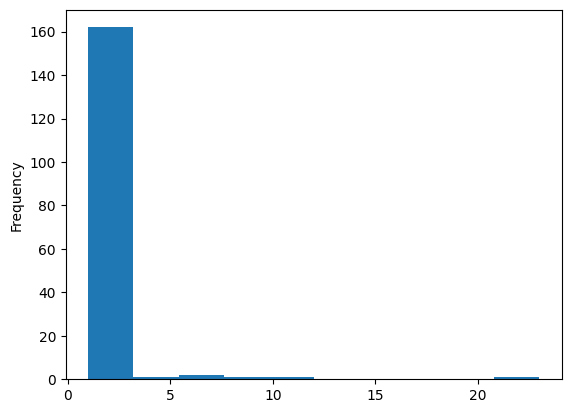

In [36]:
# Plot the number of unique users per HL tile (count of 1 means that the HL has only trips from one unique user, thus perfect clustering)
gp_combined.astype({'geometry':'string'}).groupby(['geometry'])[['PERSON_ID']].nunique().PERSON_ID.plot.hist()

In [37]:
# Number of unique users for which at least one HL was identified
gp_combined.PERSON_ID.unique().size

29

In [38]:
# Assign ID to HL
gp_combined['HL_ID'] = gp_combined.astype({'geometry': 'string'}).groupby('geometry').ngroup()

HL_table = gp_combined[['geometry', 'HL_ID']].drop_duplicates()

print(f"Number of unique HL tiles: {len(HL_table)}")

Number of unique HL tiles: 168


# Match trips with Home Location tiles

## Match concatenated trips

In [39]:
# Merge all start and enpoints of all trajectories with HL tiles
# All successfully matched trips will have 0 in the "matched_sp/ep" column else NaN
matched_sp = gp.sjoin(
    trip_sp_gdf_concat, # This data frame contains all SPs of the trips that are at the end of a concatenated trip (end of a concatenated trip)
    gp_combined.dissolve()[['geometry']], # Here we do the matching on the dissolved HL tiles since we only want to have one match per point to detect binary whether it is matched at all or not
    how="left"
).rename(columns={"index_right": "matched_sp"})

matched_ep = gp.sjoin(
    trip_ep_gdf_concat, # This data frame contains all EPs of the trips that are at the end of a concatenated trip (end of a concatenated trip)
    gp_combined.dissolve()[['geometry']], # same here, see above
    how="left"
).rename(columns={"index_right": "matched_ep"})


**Note:** Since we here match with the dissolved tile, we also can at max get ONE match per SP since overlapping HL tiles are dissolved.

In [40]:
# Merge start and endpoints of all trajectories with HL tiles to get HL_IDs for each trip
s = gp.sjoin(
    trip_sp_gdf_concat,
    HL_table,
    how="right").drop('index_left', axis=1).dropna()

e = gp.sjoin(
    trip_ep_gdf_concat, 
    HL_table, 
    how="right").drop('index_left', axis=1).dropna()

In [41]:
# Get unmatched start and endpoints
unmatched_sp_t_ids = matched_sp[matched_sp.matched_sp.isnull()].TRIP_ID.to_list()
unmatched_ep_t_ids = matched_ep[matched_ep.matched_ep.isnull()].TRIP_ID.to_list()

# Number of unmatched trajectories that do not start or end in an HL tile
nr_unmatched = len(full_trips_concat_gdf.query('TRIP_ID_FIRST in @unmatched_sp_t_ids and TRIP_ID_LAST in @unmatched_ep_t_ids'))
print(f"Number of unmatched trajectories (concatenated) that do neither start nor end in a HL tile: {nr_unmatched}/{len(full_trips_concat_gdf)}")

# Get TRIP_IDs of matched start and endpoints
matched_sp_t_ids = matched_sp[~matched_sp.matched_sp.isnull()].TRIP_ID.to_list()
matched_ep_t_ids = matched_ep[~matched_ep.matched_ep.isnull()].TRIP_ID.to_list()

print(f"Number of trajectories (concatenated) that start AND end in a HL tile: {len(full_trips_concat_gdf.query('TRIP_ID_FIRST in @matched_sp_t_ids and TRIP_ID_LAST in @matched_ep_t_ids'))}/{len(full_trips_concat_gdf)}")

# check whether number of unmatched trajectories plus number of matched trajectories do line up with the total number of trips in data (in this case concatenated trips)
assert (full_trips_concat_gdf.query("TRIP_ID_FIRST in @s.TRIP_ID or TRIP_ID_LAST in @e.TRIP_ID").TRIP_ID.nunique() + nr_unmatched) == len(full_trips_concat_gdf)

Number of unmatched trajectories (concatenated) that do neither start nor end in a HL tile: 106/2656
Number of trajectories (concatenated) that start AND end in a HL tile: 1797/2656


In [42]:
# Merge matched SP and EP to get the HL_IDs for each trip and drop duplicates.
HL_table_se_concat = pd.merge(full_trips_concat_gdf, s[['TRIP_ID', 'HL_ID']], left_on="TRIP_ID_FIRST", right_on="TRIP_ID", how="left")
HL_table_se_concat = pd.merge(HL_table_se_concat, e[['TRIP_ID', 'HL_ID']], left_on="TRIP_ID_LAST", right_on="TRIP_ID", how="left").drop(['TRIP_ID_y', 'TRIP_ID'], axis=1).rename(columns={'TRIP_ID_x': 'TRIP_ID'})
HL_table_se_concat = HL_table_se_concat[['TRIP_ID', 'HL_ID_x', 'HL_ID_y']].set_index('TRIP_ID').stack().droplevel(1).reset_index().rename(columns={0: 'HL_ID'}).drop_duplicates()

# Get trips that match different HL tiles with their SP and EP
double_assigned_trips = HL_table_se_concat.groupby('TRIP_ID').filter(lambda x: len(x) > 1)

# Get trips that are not assigned to any HL tile
unmatched_trips = full_trips_concat_gdf.query('TRIP_ID_FIRST in @unmatched_sp_t_ids and TRIP_ID_LAST in @unmatched_ep_t_ids')[['TRIP_ID']].reset_index(drop=True)
unmatched_trips['HL_ID'] = None # Get same format as HL_table_se_concat

#HL_table_se_concat['HL_ID'] = HL_table_se_concat['HL_ID_x'].combine_first(HL_table_se_concat['HL_ID_y'])
print(f"Number of trips that match different HL tiles with their SP and EP: {double_assigned_trips.TRIP_ID.nunique()}")


Number of trips that match different HL tiles with their SP and EP: 833


In [ ]:
full_trips_concat_gdf.query('TRIP_ID in @double_assigned_trips.TRIP_ID').explore()

In [78]:
HL_table_se_concat.groupby('TRIP_ID').filter(lambda x: len(x) == 1)

,TRIP_ID,HL_ID
0,2735,112.0
1,3161,154.0
2,4012,112.0
3,9660,50.0
6,11088,47.0
...,...,...
3376,26440,55.0
3377,15791,55.0
3378,14378,133.0
3379,25904,163.0


## Assign double matched trips to one unique HL

Iterate over all double matched trips and compare them to all other trips that are uniquely assigned in their respective potential HLs that they have been matched with. Then take the HL with the single maximum lcss score between the trip under question and any trip of the assigned HL tiles.

In [156]:
# Get trips that match only one HL tile with their SP and EP
uniquely_assigned_trips = HL_table_se_concat.groupby('TRIP_ID').filter(lambda x: len(x) == 1)

def compute_lcss_scores(double_assigned_trip):
    t_id = double_assigned_trip.TRIP_ID
    hl_id = double_assigned_trip.HL_ID

    # Create dict to store results for this trip and HL
    result_dict = {t_id: {hl_id: list()}}

    # Get trajectory linestring for this trip
    trip = full_trips_concat_gdf.query("TRIP_ID == @t_id")

    # Get trips that are uniquely assigned to this HL
    assigned_trips = uniquely_assigned_trips.query("HL_ID == @hl_id")

    # Loop through these trips and calc LCSS scores for each of them
    for index, assigned_trip in assigned_trips.iterrows():
        assigned_t_id = assigned_trip.TRIP_ID

        # Skip the calc for the trip with itself
        if assigned_t_id == t_id:
            continue
        # Get trajectory linestring for this trip (here we use the non-concated one since we are considering S and E points separately to match HL with the concated trips afterwards)
        a_trip = full_trips_concat_gdf.query("TRIP_ID == @assigned_t_id")

        score = LCSS(trip.geometry, a_trip.geometry)

        # save scores in list
        result_dict[t_id][hl_id].append(score)
    return result_dict

parallel_scores = Parallel(n_jobs=-2, verbose=10)(delayed(compute_lcss_scores)(double_assigned_trip) for index, double_assigned_trip in double_assigned_trips.iterrows())

# Flatten the list of dicts from parallel processing
lcss_scores = {}
for idx, trip in enumerate(parallel_scores):
    for t_id in trip:

        # create dict for this trip if not yet existing (it would if another HL this trip was joined with has already been checked)
        if t_id not in lcss_scores:
            lcss_scores[t_id] = {}

        for hl_id in parallel_scores[idx][t_id]:
            # create new list for this HL under the trip key
            lcss_scores[t_id][hl_id] = parallel_scores[idx][t_id][hl_id]

# Get and compare max scores across all matched HL for a trip and assign the HL with the max value of any trip
for trip in lcss_scores:
    for key in lcss_scores[trip]:
        if len(lcss_scores[trip][key]) > 0:
            lcss_scores[trip][key] = max(lcss_scores[trip][key])
        else:
            lcss_scores[trip][key] = 0
    
    lcss_scores[trip] = max(lcss_scores[trip], key=lcss_scores[trip].get)


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 out of  10 | elapsed:    1.1s remaining:    2.7s
[Parallel(n_jobs=-2)]: Done   5 out of  10 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=-2)]: Done   7 out of  10 | elapsed:    2.7s remaining:    1.1s
[Parallel(n_jobs=-2)]: Done  10 out of  10 | elapsed:    8.2s finished


In [159]:
# Assign resolved scores to se_HL_lookup table and drop duplicates
HL_table_se_concat['HL_ID'] = HL_table_se_concat.apply(lambda x: lcss_scores[x['TRIP_ID']] if x['TRIP_ID'] in lcss_scores else x['HL_ID'], axis=1)
HL_table_se_concat = HL_table_se_concat.drop_duplicates(['TRIP_ID', 'HL_ID']).reset_index(drop=True)

# Assert that the number of trips that are matched to a HL tile plus the the nr of trips that are unmatched is equal to the total number of concatenated trips
assert len(HL_table_se_concat) + nr_unmatched == len(full_trips_concat_gdf)

# Combine resolved HL HL_table_se_concat with the unmatched trips to get full HL_table for all trips
HL_table_trips_concat = pd.concat([HL_table_se_concat, unmatched_trips], ignore_index=True)
HL_table_trips_concat.loc[HL_table_trips_concat.HL_ID.isnull(), 'HL_ID'] = 'no_match' # assign HL_ID 'no_match' to unmatched trips

AssertionError: 

The following code block is only needed if we match the individual trip with HL tiles instead of the concatenated. This for loops finds the best-fitting HL for the concatenated trip, given the unique assignments to HLs available to the first and last trips of this chain.

In [89]:
for index, row in full_trips_concat_gdf.iterrows():
    t_id = row['TRIP_ID']
    t_id_last = row['TRIP_ID_LAST']

    scores = {}

    # check if both SP and EP of trip are matched with HL and contained in se_HL table
    if t_id in HL_table_se_concat.TRIP_ID.values and t_id_last in HL_table_se_concat.TRIP_ID.values:
        s_hl = HL_table_se_concat.query("TRIP_ID == @t_id").HL_ID.iloc[0]
        e_hl = HL_table_se_concat.query("TRIP_ID == @t_id_last").HL_ID.iloc[0]
        
        if s_hl == e_hl:
            row['HL_ID'] = s_hl
        else:
            # Get trips that are currently assigned to sp HL
            assigned_trips = HL_table_se_concat.query("HL_ID == @s_hl")
            print(s_hl)
            print(e_hl)

            scores[s_hl] = []

            # Loop through these trips and calc LCSS scores for each of them
            for index, assigned_trip in assigned_trips.iterrows():
                assigned_t_id = assigned_trip.TRIP_ID
                # Skip the calc for the trip with itself
                if assigned_t_id == t_id:
                    continue

                # Get trajectory linestring for this trip (here we use the non-concatenated frame since we are considering SP and EP from individual trips)
                a_trip = full_trip_gdf.query("TRIP_ID == @assigned_t_id")

                score = LCSS(row.geometry, a_trip.geometry)

                # save scores in list
                scores[s_hl].append(score)

            

            # Get trips that are currently assigned to ep HL
            assigned_trips = HL_table_se_concat.query("HL_ID == @e_hl")

            scores[e_hl] = []

            # Loop through these trips and calc LCSS scores for each of them
            for index, assigned_trip in assigned_trips.iterrows():
                assigned_t_id = assigned_trip.TRIP_ID
                # Skip the calc for the trip with itself
                if assigned_t_id == t_id_last:
                    continue
                # Get trajectory linestring for this trip (here we use the non-concatenated frame since we are considering SP and EP from individual trips)
                a_trip = full_trip_gdf.query("TRIP_ID == @assigned_t_id")

                score = LCSS(row.geometry, a_trip.geometry)

                # save scores in list
                scores[e_hl].append(score)

            print(scores)
            

            for key in scores:
                if len(scores[key]) > 0:
                    scores[key] = max(scores[key])
                else:
                    scores[key] = 0
            
            # get maximum score across all keys and return corresponding key (HL_ID)
            row['HL_ID'] = max(scores, key=scores.get)

            print(row['HL_ID'])
                


## Get trajectories that happened during the same time

In [171]:
def getTripOverlaps(gdf):
    """This function calculates whether two trips overlap in time.

    Args:
        gdf (_type_): The GeoDataFrame containing the trips.

    Returns:
        _type_: Dictionary with trip IDs as keys and a list of trip IDs that overlap with the key trip as values.
    """
    def getOverlaps(trip_x):
        overlap_dict = {}
        overlaps = []
        ts_x = pd.to_datetime(trip_x['TRIP_START'], format='%Y-%m-%d %H:%M:%S')
        te_x = pd.to_datetime(trip_x['TRIP_END'], format='%Y-%m-%d %H:%M:%S')
        i = 0

        for index_y, trip_y in gdf.iterrows():
            ts_y = pd.to_datetime(trip_y['TRIP_START'], format='%Y-%m-%d %H:%M:%S')
            te_y = pd.to_datetime(trip_y['TRIP_END'], format='%Y-%m-%d %H:%M:%S')

            if ts_x <= ts_y and te_x >= ts_y and (trip_x.TRIP_ID != trip_y.TRIP_ID): 
                overlaps.append(trip_y['TRIP_ID'])
            else:
                pass
            
        overlap_dict[trip_x['TRIP_ID']] = overlaps

        return overlap_dict

    overlap_dicts = Parallel(n_jobs=-2, verbose=10)(delayed(getOverlaps)(trip_x) for index_x, trip_x in gdf.iterrows())

    return {k: v for d in overlap_dicts for k, v in d.items()}


In [172]:
full_trips_concat_gdf_overlap_dict = getTripOverlaps(full_trips_concat_gdf)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   3 out of  10 | elapsed:    4.8s remaining:   11.3s
[Parallel(n_jobs=-2)]: Done   5 out of  10 | elapsed:    6.2s remaining:    6.2s
[Parallel(n_jobs=-2)]: Done   7 out of  10 | elapsed:    7.1s remaining:    3.0s
[Parallel(n_jobs=-2)]: Done  10 out of  10 | elapsed:    7.8s finished


## Create clustering after HL assignment step

In [92]:
def getOverlappingTrips(traj_id_list):
    """This function finds the overlapping trips for a list of trajectory IDs.

    Args:
        traj_id_list (_type_): List of trajectory IDs.
    """
    overlapping_trips = [item for sublist in [full_trips_concat_gdf_overlap_dict[t] for t in traj_id_list] for item in sublist] # we first get a list of lists and then flatten it
    return overlapping_trips

def findLargestNonSimultaneousSubset(traj_id_list):
    """This function finds the largest subset of trajectories that are not simultaneous.

    Args:
        traj_id_list (list): List of trajectory IDs.

    Returns:
        list: List of trajectory IDs that are not simultaneous.
    """
    len_traj_id_list = len(traj_id_list)

    # We create a list of all possible subsets of the trajectory ID list with decreasing length
    # We do this iteratively to not overload the memory
    for i in range(len_traj_id_list):
        # Create a list of all possible subsets of the trajectory ID list with length len_traj_id_list - i
        subsets = list(itertools.combinations(traj_id_list, len_traj_id_list - i))
    
        # Sort the list by length of the subsets
        subsets.sort(key=len, reverse=True)

        # Loop through the list of subsets
        for subset in subsets:
            # get all trips that do overlap in time with any of the trips in subset
            overlapping_trips = getOverlappingTrips(subset)

            # Check if the subset is not simultaneous
            if all([t not in overlapping_trips for t in subset]):
                # If so, return the subset as list
                return list(subset)

    # If no subset is found, return an empty list
    return []

In [97]:
# This creates the array with clustering IDs after the concatenation step
clustering_after_HL = {}
HL_table_dict = (HL_table_trips_concat.groupby('HL_ID')
       .apply(lambda x: list(dict(x.TRIP_ID).values()))
       .to_dict())

for index, HL in tqdm(enumerate(HL_table_dict), total=len(HL_table_dict)):
    # Skip HL_ID 'no_match', we will assign a clustering ID to these trips later
    if HL == 'no_match':
        continue

    # find the largest subset of trips that are not simultaneous
    non_simultaneous_subset = findLargestNonSimultaneousSubset(HL_table_dict[HL])

    # assign 'no_match' to all trips that are not part of the largest subset
    for trip in HL_table_dict[HL]:
        if trip not in non_simultaneous_subset:
            HL_table_dict['no_match'].append(trip)

    # Loop through all trips that are assigned to this HL_ID and assign the same clustering ID to all of them
    for trip in non_simultaneous_subset:
        clustering_after_HL[getIndexInList(trip, full_trip_gdf)] = index

        # Check if this trip is a concatenated trip and assign the same clustering ID to all trips that are part of the concatenated trip
        if trip in trip_concat_dict:
            for t in trip_concat_dict[trip]:
                clustering_after_HL[getIndexInList(t, full_trip_gdf)] = index

# Assign clustering IDs to all 'no_match' trips (these are the trips that were not successfully assigned to any HL_ID)
for index, unm_trip in enumerate(HL_table_dict['no_match']):
    clustering_after_HL[getIndexInList(unm_trip, full_trip_gdf)] = index + len(HL_table_dict) - 1 # -1 because we don't want to count the 'no_match' HL_ID in the length of HL_table_dict

    # Check if this trip is a concatenated trip and assign the same clustering ID to all trips that are part of the concatenated trip
    if unm_trip in trip_concat_dict:
        for t in trip_concat_dict[unm_trip]:
            clustering_after_HL[getIndexInList(t, full_trip_gdf)] = index + len(HL_table_dict) - 1




 21%|██▏       | 23/107 [06:20<23:10, 16.55s/it]


KeyboardInterrupt: 

## Assign Trips Without Match

In [ ]:
# This compares all trips that were not assigned to any HL_ID with all trips that were assigned to a HL_ID and assigns the clustering ID of the trip with the highest LCSS score above a certain threshold
SIM_THRESH_FOR_NO_MATCH = 0.5
new_cluster_ids = []
for unm_trip in tqdm(HL_table_dict['no_match'], total=len(HL_table_dict['no_match'])):
    # compute LCSS for all HL_IDs in clustering_after_HL
    print(unm_trip)
    scores = {}
    for hl_id, trips in HL_table_dict.items():
        scores[hl_id] = {}
        for t in trips:
            if t != unm_trip: # don't compare trip with itself
                scores[hl_id][t] = LCSS(full_trips_concat_gdf.query("TRIP_ID == @unm_trip").geometry, full_trips_concat_gdf.query("TRIP_ID == @t").geometry)

        # find the trip with the highest LCSS score for current HL_ID
        max_score = max(scores[hl_id].values())
        scores[hl_id] = max_score

    max_score_across_hl_id = max(scores.values())
    max_score_hl_id = [k for k, v in scores.items() if v == max_score_across_hl_id]
    print(max_score_hl_id) #  in theory there could be two trips of different HL_ids with the same LCSS score. This is why this is a list
    print(max_score_across_hl_id)

    # throw error if length of max_score_hl_id is greater than 1 and the max_score_across_hl_id is above the threshold
    if len(max_score_hl_id) > 1 and max_score_across_hl_id > SIM_THRESH_FOR_NO_MATCH:
        raise ValueError("There are two HL_IDs with the same LCSS score")
    else:
        max_score_hl_id = max_score_hl_id[0]

    # if the highest LCSS score is above the threshold and the trips that have the highest LCSS score do not overlap in time
    if max_score_across_hl_id > SIM_THRESH_FOR_NO_MATCH and unm_trip not in getOverlappingTrips(HL_table_dict[max_score_hl_id]): 
        # if hl_id of matched hl_id is 'no_match' then create new cluster for the two trips
        if max_score_hl_id == 'no_match':
            print("no match and assign new cluster id", max(clustering_after_HL.values()) + 1, "to trips", unm_trip, max_score_hl_id)
            # create new cluster with ID that is one higher than the highest clustering ID
            HL_table_dict[max(clustering_after_HL.values()) + 1] = [unm_trip, max_score_hl_id]
            new_cluster_ids.append(max(clustering_after_HL.values()) + 1)

        # if hl_id of matched hl_id is not 'no_match' then assign the clustering ID of the matched HL_ID to the trip
        else:
            print("existing match and assign cluster id", max_score_hl_id, "to trip", unm_trip)
            # Append the trip to the list of trips that are part of the HL_ID with the highest LCSS score
            HL_table_dict[max_score_hl_id].append(unm_trip)

            # assign the clustering ID of the HL_ID with the highest LCSS score to the trip
            # This overwrites the previous clustering ID of the trip that was assigned in the previous step
            clustering_after_HL[getIndexInList(unm_trip)] = clustering_after_HL[getIndexInList(HL_table_dict[max_score_hl_id][0])] # This is a list of length one as asserted above

            # Check if this trip is a concatenated trip and assign the same clustering ID to all trips that are part of the concatenated trip
            if unm_trip in trip_concat_dict:
                for t in trip_concat_dict[unm_trip]:
                    clustering_after_HL[getIndexInList(t)] = clustering_after_HL[getIndexInList(HL_table_dict[max_score_hl_id][0])] # This is a list of length one as asserted above
    else:
        # if trip overlaps in time with other trips in the same HL_ID
        if unm_trip in getOverlappingTrips(HL_table_dict[max_score_hl_id]):
            print("trip overlaps in time with other trips in the same HL_ID")
        
        

# Assign clustering IDs to all trips that are part of a new cluster
for cluster_id in new_cluster_ids:
    for trip in HL_table_dict[cluster_id]:
        clustering_after_HL[getIndexInList(trip)] = cluster_id


In [ ]:
m = full_trips_concat_gdf.query("TRIP_ID == 993106").explore(color='purple')

hl_trips = HL_table_dict[58]

full_trips_concat_gdf.query("TRIP_ID in @hl_trips").explore(m = m)

In [ ]:
clustering_HL = list(dict(sorted(clustering_HL.items())).values())

print(f"Number of unique clusters: {len(set(clustering_HL))}")

Number of unique clusters: 277


In [ ]:
print("Clustering results after concatenation step:")
#evaluate(clustering_concat)
print("\nClustering results after HL matching step:")
evaluate(clustering_HL)

Clustering results after concatenation step:

Clustering results after HL matching step:
Accuracy@1: 0.963
Precision: 0.935
Recall: 0.950
F1: 0.942
Homogeneity: 0.961
Completeness: 0.737
V-measure: 0.834
Rand index: 0.981
ARI: 0.557
MI: 3.560
NMI: 0.834
AMI: 0.705


c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Bened\Documents\Git\Master-Thesis\env\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of